In [ ]:
!git clone https://github.com/shaoanlu/GazeML-keras.git

In [ ]:
%cd "GazeML-keras"

In [1]:
# CPU inference
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
from detector.face_detector import MTCNNFaceDetector
from models.elg_keras import KerasELG
from keras import backend as K

import numpy as np
import cv2
from matplotlib import pyplot as plt

Using TensorFlow backend.


## Face detector

We apply MTCNN for face and 5-points landmarks detection.

In [3]:
mtcnn_weights_dir = "./mtcnn_weights/"
fd = MTCNNFaceDetector(sess=K.get_session(), model_path=mtcnn_weights_dir)

## GazeML ELG model

A stacked hourglass architecture for iris and eye-lid detection.

In [4]:
model = KerasELG()
model.net.load_weights("./elg_weights/elg_keras.h5")

## Load image

In [117]:
fn = "./test_imgs/Lenna_(test_image).png"
input_img = cv2.imread(fn)[..., ::-1]

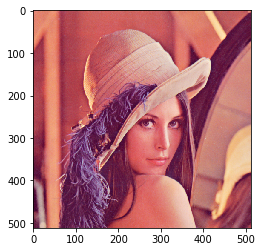

In [118]:
plt.imshow(input_img)

## Apply face detection

Input: RGB image

Outputs: face bounding box and 5-points landmarks

In [120]:
face, lms = fd.detect_face(input_img)

## Visualize detection

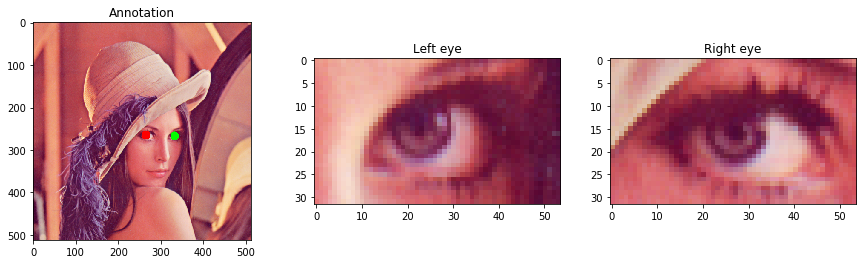

In [121]:
left_eye_xy = np.array([lms[6], lms[1]])
right_eye_xy = np.array([lms[5], lms[0]])

dist_eyes = np.linalg.norm(left_eye_xy - right_eye_xy)
eye_bbox_w = (dist_eyes / 1.2)
eye_bbox_h = (eye_bbox_w *0.6)

left_eye_xy, right_eye_xy = map(np.int32, [left_eye_xy, right_eye_xy])
eye_bbox_w, eye_bbox_h = map(np.int32, [eye_bbox_w, eye_bbox_h])
left_eye_im = input_img[
    int(left_eye_xy[0]-eye_bbox_h//2):int(left_eye_xy[0]+eye_bbox_h//2),
    int(left_eye_xy[1]-eye_bbox_w//2):int(left_eye_xy[1]+eye_bbox_w//2),
    :
]
#left_eye_im = left_eye_im[:,::-1,:] # No need for flipping left eye for iris detection
right_eye_im = input_img[
    int(right_eye_xy[0]-eye_bbox_h//2):int(right_eye_xy[0]+eye_bbox_h//2),
    int(right_eye_xy[1]-eye_bbox_w//2):int(right_eye_xy[1]+eye_bbox_w//2),
    :
]

plt.figure(figsize=(15,4))
draw = input_img.copy()
for i, lm in enumerate([left_eye_xy.astype(np.int32), right_eye_xy.astype(np.int32)]):
    draw = cv2.circle(draw, (int(lm[1]), int(lm[0])), 10, (255*i,255*(1-i),0), -1)
plt.subplot(1,3,1)
plt.title('Annotation')
plt.imshow(draw)
plt.subplot(1,3,2)
plt.title('Left eye')
plt.imshow(left_eye_im)
plt.subplot(1,3,3)
plt.title('Right eye')
plt.imshow(right_eye_im)

## Preprocess eye images

In [122]:
inp_left = cv2.equalizeHist(cv2.cvtColor(left_eye_im, cv2.COLOR_RGB2GRAY))
inp_left = cv2.resize(inp_left, (180,108))[np.newaxis, ..., np.newaxis]

inp_right = cv2.equalizeHist(cv2.cvtColor(right_eye_im, cv2.COLOR_RGB2GRAY))
inp_right = cv2.resize(inp_right, (180,108))[np.newaxis, ..., np.newaxis]

## ELG forward pass

In [123]:
input_array = np.concatenate([inp_left, inp_right], axis=0)
pred_left, pred_right = model.net.predict(input_array/255 * 2 - 1)

# Visualize eye region landmarks

In [124]:
def draw_pupil(im, inp_im, lms):
    draw = im.copy()
    draw = cv2.resize(draw, (inp_im.shape[2], inp_im.shape[1]))
    pupil_center = np.zeros((2,))
    pnts_outerline = []
    pnts_innerline = []
    for i, lm in enumerate(np.squeeze(lms)):
        #print(lm)
        y, x = int(lm[0]*3), int(lm[1]*3)

        if i < 8:
            draw = cv2.circle(draw, (y, x), 3, (125,255,125), -1)
            pnts_outerline.append([y, x])
        elif i < 16:
            draw = cv2.circle(draw, (y, x), 3, (125,125,255), -1)
            pnts_innerline.append([y, x])
            pupil_center += (y,x)
        elif i < 17:
            draw = cv2.drawMarker(draw, (y, x), (255,200,200), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=2, line_type=cv2.LINE_AA)
        else:
            draw = cv2.drawMarker(draw, (y, x), (255,125,125), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=2, line_type=cv2.LINE_AA)
    pupil_center = (pupil_center/8).astype(np.int32)
    draw = cv2.cv2.circle(draw, (pupil_center[0], pupil_center[1]), 5, (255,255,0), -1)        
    draw = cv2.polylines(draw, [np.array(pnts_outerline).reshape(-1,1,2)], isClosed=True, color=(125,255,125), thickness=3)
    draw = cv2.polylines(draw, [np.array(pnts_innerline).reshape(-1,1,2)], isClosed=True, color=(125,125,255), thickness=3)
    return draw

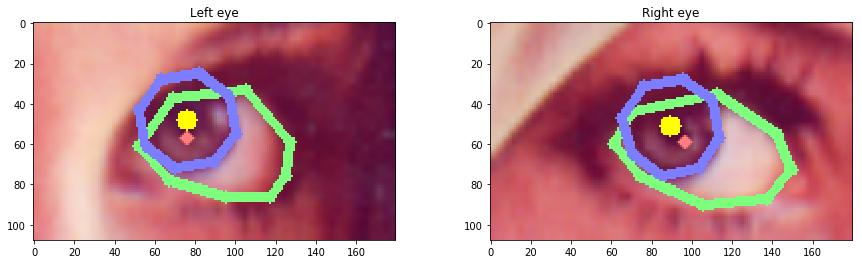

In [125]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("Left eye")
lms_left = model._calculate_landmarks(pred_left)
result_left = draw_pupil(left_eye_im, inp_left, lms_left)
plt.imshow(result_left)
plt.subplot(1,2,2)
plt.title("Right eye")
lms_right = model._calculate_landmarks(pred_right)
result_right = draw_pupil(right_eye_im, inp_right, lms_right)
plt.imshow(result_right)

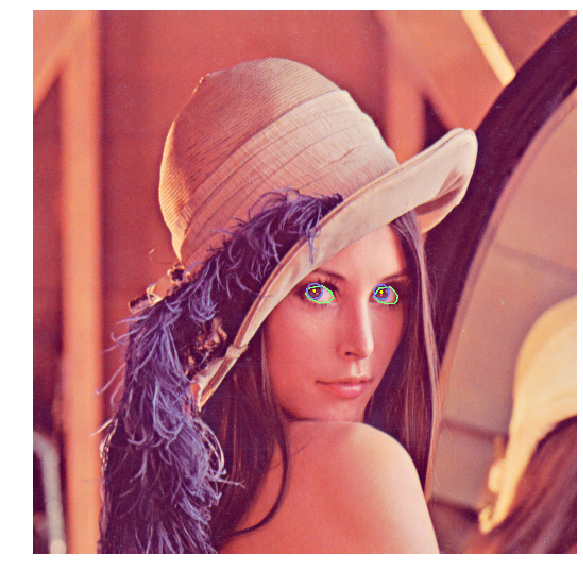

In [126]:
draw2 = input_img.copy()

slice_h = slice(int(left_eye_xy[0]-eye_bbox_h//2), int(left_eye_xy[0]+eye_bbox_h//2))
slice_w = slice(int(left_eye_xy[1]-eye_bbox_w//2), int(left_eye_xy[1]+eye_bbox_w//2))
im_shape = left_eye_im.shape[::-1]

draw2[slice_h, slice_w, :] = cv2.resize(result_left, im_shape[1:])

slice_h = slice(int(right_eye_xy[0]-eye_bbox_h//2), int(right_eye_xy[0]+eye_bbox_h//2))
slice_w = slice(int(right_eye_xy[1]-eye_bbox_w//2), int(right_eye_xy[1]+eye_bbox_w//2))
im_shape = right_eye_im.shape[::-1]

draw2[slice_h, slice_w, :] = cv2.resize(result_right, im_shape[1:])

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(draw2)